In [1]:
import numpy as np
import math, random
from tqdm.notebook import tqdm
from tensorflow_privacy.privacy.optimizers.dp_optimizer import *
import pandas as pd
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import random; random.seed(42)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import tensorflow as tf

%load_ext autoreload
%autoreload 2

tf.compat.v1.enable_eager_execution()
assert tf.executing_eagerly

Using TensorFlow backend.


DP-SGD has three privacy-specific hyperparameters and one existing hyperamater that you must tune:

1. `l2_norm_clip` (float) - The maximum Euclidean (L2) norm of each gradient that is applied to update model parameters. This hyperparameter is used to bound the optimizer's sensitivity to individual training points. 
2. `noise_multiplier` (float) - The amount of noise sampled and added to gradients during training. Generally, more noise results in better privacy (often, but not necessarily, at the expense of lower utility).
3.   `microbatches` (int) - Each batch of data is split in smaller units called microbatches. By default, each microbatch should contain a single training example. This allows us to clip gradients on a per-example basis rather than after they have been averaged across the minibatch. This in turn decreases the (negative) effect of clipping on signal found in the gradient and typically maximizes utility. However, computational overhead can be reduced by increasing the size of microbatches to include more than one training examples. The average gradient across these multiple training examples is then clipped. The total number of examples consumed in a batch, i.e., one step of gradient descent, remains the same. The number of microbatches should evenly divide the batch size. 

In [2]:
# Hyperparameters

epochs = 2
batch_size = 125
public_data_size = 250 # Multiple of batch_size
l2_norm_clip = 0.5
noise_multiplier = 1
num_microbatches = batch_size
learning_rate=1e-3

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [3]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255
train_data = np.expand_dims(train_data, len(train_data.shape))
test_data = np.expand_dims(test_data, len(test_data.shape))

train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

In [4]:
from sklearn.model_selection import train_test_split

# test_size refers to private data size
test_size = (train_data.shape[0] - public_data_size) / train_data.shape[0]

public_data, private_data, public_labels, private_labels = \
    train_test_split(train_data, train_labels, test_size=test_size)

num_batches = private_data.shape[0] // batch_size

In [5]:
print(public_data.shape)
print(public_labels.shape)
print(private_data.shape)
print(private_labels.shape)

(250, 28, 28, 1)
(250, 10)
(59750, 28, 28, 1)
(59750, 10)


In [6]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

n = private_labels.shape[0]
delta = 1e-5
epsilon, _ = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
    n=n, batch_size=batch_size, noise_multiplier=noise_multiplier, epochs=epochs, delta=delta)

DP-SGD with sampling rate = 0.209% and noise_multiplier = 1 iterated over 956 steps satisfies differential privacy with eps = 1.12 and delta = 1e-05.
The optimal RDP order is 12.0.


In [7]:
# CNN model from the paper
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def cnn_model():
    model = tf.keras.models.Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(60, activation='linear', use_bias=False))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    model.load_weights('mnist_abadi_weights.h5')
    
    return model

In [8]:
# L2 norm clip for Gaussian + sign sgd
num_params = cnn_model().count_params()
sign_l2_norm_clip = math.sqrt(num_params)

# Compute appropriate parameters for randomized response

sampling_ratio = batch_size / n
num_steps = int(math.ceil(epochs * n / batch_size))
# This is basic composition. TODO: change to advanced composition
single_step_epsilon = epsilon / num_steps / sampling_ratio

def sigmoid(x):
    return 1 / (1 + math.exp(-x))
rr_preserve_prob = sigmoid(single_step_epsilon / num_params)
print(rr_preserve_prob)

0.5000011899403002


In [9]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [10]:
def get_public_grads_mean_var(public_x, public_y, loss_fn, model):
    # x needs to have extra dimension for number of examples,
    # even if it's 1 for our case
    public_x = np.expand_dims(public_x, axis=1)
    # https://math.stackexchange.com/questions/20593/calculate-variance-from-a-stream-of-sample-values
    mean_k = None
    v_k = None
    k = 0
    for x, y in zip(public_x, public_y):
        k += 1
        with tf.GradientTape() as tape:
            loss_value = loss_fn(y, model(x))
            grad = tape.gradient(loss_value, model.trainable_weights)
        numpy_grad = [t.numpy() for t in grad]
        if k == 1:
            mean_k = numpy_grad
            v_k = [np.zeros(t.shape) for t in numpy_grad]
        else:
            prev_mean_k = mean_k
            mean_k = [mean_k[i] + (t - mean_k[i]) / k for i, t in enumerate(numpy_grad)]
            v_k = [v_k[i] +  np.multiply(t - prev_mean_k[i], 
                                         t - mean_k[i]) 
                   for i, t in enumerate(numpy_grad)]
    unbiased_variance = [t / (k - 1) for t in v_k]
    return mean_k, unbiased_variance

def get_grads_mean(xs, ys, loss_fn, model, 
                      l2_norm_clip=None, noise_multiplier=None, rr_preserve_prob=None, sign=False, dp=False):
    xs = np.expand_dims(xs, axis=1)
    n = xs.shape[0]
    
    grads_mean = None
    for i, (x, y) in enumerate(zip(xs, ys)):
        with tf.GradientTape() as tape:
            loss_value = loss_fn(y, model(x))
        grad = [t.numpy() for t in tape.gradient(loss_value, model.trainable_weights)]
        if sign:
            grad = [np.sign(t) for t in grad]
        if dp:
            grad = make_grad_dp_gaussian(grad, l2_norm_clip, noise_multiplier)
        if sign and dp:
            # Sign again
            grad = [np.sign(t) for t in grad]
        if not grads_mean:
            grads_mean = [np.zeros(l.shape, dtype=np.float32) for l in grad]
        grads_mean = [grads_mean[j] + (l - grads_mean[j]) / (i+1) for j, l in enumerate(grad)]
    return grads_mean

def get_grad_norm(grad):
    summed = sum([np.sum(np.square(layer)) for layer in grad])
    return math.sqrt(summed)

def clip_grad(grad, l2_norm_clip):
    norm_scale = l2_norm_clip / get_grad_norm(grad)
    scaled_grad = [t * norm_scale for t in grad]
    return scaled_grad
    
def make_grad_dp_gaussian(grad, l2_norm_clip, noise_multiplier):
    clipped_grad = clip_grad(grad, l2_norm_clip)
    noised_grad = [t + np.random.normal(0, l2_norm_clip * noise_multiplier, t.shape).astype(np.float32)
                        for t in clipped_grad]
    return noised_grad

def random_binary_arr(arr):
    bool_arr = np.random.randint(2, size=arr.shape)
    bool_arr[bool_arr == 0] = -1
    return bool_arr

def random_grad(grad):
    return [random_binary_arr(t) for t in grad]

def make_grad_sign_dp_rr(grad, preserve_prob):
    grad = [np.sign(t) for t in grad]
    choice = [np.random.uniform(size=t.shape) for t in grad]
    mask = [t <= preserve_prob for t in choice]
    for i, rdm in enumerate(random_grad(grad)):
        grad[i][mask[i]] = rdm[mask[i]]
    return grad

def evaluate_model(model, loss_fn, x, y):
    pred = model(x)
    loss = np.mean(loss_fn(y, pred).numpy())
    acc = np.mean(tf.keras.metrics.categorical_accuracy(y, pred).numpy())
    return (loss, acc)

In [11]:
# from tensorflow.keras.callbacks import EarlyStopping

# pretrained_model = cnn_model()
# pretrained_model.compile(optimizer='adam',
#                        loss=loss_fn, metrics=['accuracy'])
# baseline_history = pretrained_model.fit(public_data, public_labels,
#                     epochs=50,
#                     batch_size=batch_size,
#                     verbose=0,
#                     callbacks=[TQDMNotebookCallback(), EarlyStopping(monitor='acc', patience=5)])
# evaluate_model(pretrained_model, loss_fn, test_data, test_labels)

(1.6559538, 0.817)

In [12]:
normal_sgd_model = cnn_model()
normal_sgd_optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)
normal_sgd_model.compile(optimizer=normal_sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

sign_sgd_model = cnn_model()
sign_sgd_optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)
sign_sgd_model.compile(optimizer=sign_sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

dp_sign_sgd_model = cnn_model()
dp_sign_sgd_optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)
dp_sign_sgd_model.compile(optimizer=dp_sign_sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

dpsgd_model = cnn_model()
dpsgd_optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)
dpsgd_model.compile(optimizer=dpsgd_optimizer, loss=loss_fn, metrics=['accuracy'])

# custom_model_pretrained = cnn_model()
# custom_model_pretrained.set_weights(pretrained_model.get_weights())
# custom_optimizer_pretrained = DPGradientDescentGaussianOptimizer(
#     l2_norm_clip=l2_norm_clip,
#     noise_multiplier=noise_multiplier,
#     num_microbatches=num_microbatches,
#     learning_rate=learning_rate)
# custom_model_pretrained.compile(optimizer=custom_optimizer_pretrained, loss=loss_fn, metrics=['accuracy'])

# dpsgd_model_pretrained = cnn_model()
# dpsgd_model_pretrained.set_weights(pretrained_model.get_weights())
# dpsgd_optimizer_pretrained = DPGradientDescentGaussianOptimizer(
#     l2_norm_clip=l2_norm_clip,
#     noise_multiplier=noise_multiplier,
#     num_microbatches=num_microbatches,
#     learning_rate=learning_rate)
# dpsgd_model_pretrained.compile(optimizer=dpsgd_optimizer_pretrained, loss=loss_fn, metrics=['accuracy'])

In [13]:
# Iterate over epochs.
normal_sgd_loss_batches = []
normal_sgd_acc_batches = []

sign_sgd_loss_batches = []
sign_sgd_acc_batches = []

dp_sign_sgd_loss_batches = []
dp_sign_sgd_acc_batches = []

dpsgd_loss_batches = []
dpsgd_acc_batches = []

dpsgd_loss_pretrained_batches = []
dpsgd_acc_pretrained_batches = []

# Used for picking a random minibatch
idx_array = np.arange(private_data.shape[0])

for epoch in tqdm(range(epochs), desc='Epoch'):

    # Iterate over the batches of the dataset.
    for step in tqdm(range(num_batches), desc='Batch', leave=False):
        
        # Pick a random minibatch
        random_idx = np.random.choice(idx_array, batch_size)
        x_batch_train = private_data[random_idx]
        y_batch_train = private_labels[random_idx]
        
        ### Normal SGD
        
        # Evaluate model
        loss, acc = evaluate_model(normal_sgd_model, loss_fn, test_data, test_labels)
        normal_sgd_loss_batches.append(loss)
        normal_sgd_acc_batches.append(acc)
        
        with tf.GradientTape() as tape:
            loss_val = loss_fn(y_batch_train, normal_sgd_model(x_batch_train)) # Compute loss value
            
        grads = tape.gradient(loss_val, normal_sgd_model.trainable_variables)
        normal_sgd_optimizer.apply_gradients(zip(grads, normal_sgd_model.trainable_variables))
        
        ### Sign SGD
        
        # Evaluate model
        loss, acc = evaluate_model(sign_sgd_model, loss_fn, test_data, test_labels)
        sign_sgd_loss_batches.append(loss)
        sign_sgd_acc_batches.append(acc)
        
        grads = get_grads_mean(
            x_batch_train, y_batch_train, loss_fn, sign_sgd_model, 
            rr_preserve_prob=rr_preserve_prob, sign=True, dp=False)
        
        sign_sgd_optimizer.apply_gradients(zip(grads, sign_sgd_model.trainable_variables))
        
        ### DP SignSGD
        
        # Evaluate model
        loss, acc = evaluate_model(dp_sign_sgd_model, loss_fn, test_data, test_labels)
        dp_sign_sgd_loss_batches.append(loss)
        dp_sign_sgd_acc_batches.append(acc)
        
        grads = get_grads_mean(
            x_batch_train, y_batch_train, loss_fn, dp_sign_sgd_model, 
            l2_norm_clip=sign_l2_norm_clip, noise_multiplier=noise_multiplier, sign=True, dp=True)
        
        dp_sign_sgd_optimizer.apply_gradients(zip(grads, dp_sign_sgd_model.trainable_variables))
        
        ### Normal DPSGD
    
        # Evaluate DPSGD model
        loss, acc = evaluate_model(dpsgd_model, loss_fn, test_data, test_labels)
#         print('DPSGD Loss: %.4f | Acc: %.4f' % (loss, acc))
        dpsgd_loss_batches.append(loss)
        dpsgd_acc_batches.append(acc)
    
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = dpsgd_model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss = lambda: loss_fn(y_batch_train, logits)

            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = dpsgd_optimizer.compute_gradients(
                loss, dpsgd_model.trainable_weights, gradient_tape=tape)

        del tape

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        dpsgd_optimizer.apply_gradients(grads)
        
#         ### Normal DPSGD pretrained
    
#         # Evaluate DPSGD model
#         loss, acc = evaluate_model(dpsgd_model_pretrained, loss_fn, test_data, test_labels)
# #         print('DPSGD Loss: %.4f | Acc: %.4f' % (loss, acc))
#         dpsgd_loss_pretrained_batches.append(loss)
#         dpsgd_acc_pretrained_batches.append(acc)
    
#         # Open a GradientTape to record the operations run
#         # during the forward pass, which enables autodifferentiation.
#         with tf.GradientTape(persistent=True) as tape:

#             # Run the forward pass of the layer.
#             # The operations that the layer applies
#             # to its inputs are going to be recorded
#             # on the GradientTape.
#             logits = dpsgd_model_pretrained(x_batch_train)  # Logits for this minibatch

#             # Compute the loss value for this minibatch.
#             loss = lambda: loss_fn(y_batch_train, logits)

#             # Use the gradient tape to automatically retrieve
#             # the gradients of the trainable variables with respect to the loss.
#             grads = dpsgd_optimizer_pretrained.compute_gradients(
#                 loss, dpsgd_model_pretrained.trainable_weights, gradient_tape=tape)

#         del tape

#         # Run one step of gradient descent by updating
#         # the value of the variables to minimize the loss.
#         dpsgd_optimizer_pretrained.apply_gradients(grads)

Instructions for updating:
Use tf.identity instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
print(evaluate_model(normal_sgd_model, loss_fn, test_data, test_labels))
print(evaluate_model(sign_sgd_model, loss_fn, test_data, test_labels))
print(evaluate_model(dp_sign_sgd_model, loss_fn, test_data, test_labels))
print(evaluate_model(dpsgd_model, loss_fn, test_data, test_labels))

(1.627382, 0.8421)
(1.819834, 0.6339)
(2.2978303, 0.1725)
(2.2979841, 0.1658)


In [22]:
metrics = pd.DataFrame({
#                         'non-dp_acc': normal_sgd_acc_batches,
#                         'signsgd_acc': sign_sgd_acc_batches,
                        'dp-signsgd_acc': dp_sign_sgd_acc_batches,
                        'dpsgd_acc': dpsgd_acc_batches,
#                         'dpsgd_pretrained_acc': dpsgd_acc_pretrained_batches,
                       })
print(metrics)

     dp-signsgd_acc  dpsgd_acc
0            0.1182     0.1182
1            0.1182     0.1183
2            0.1181     0.1183
3            0.1182     0.1183
4            0.1181     0.1184
..              ...        ...
951          0.1722     0.1656
952          0.1724     0.1656
953          0.1725     0.1656
954          0.1719     0.1656
955          0.1718     0.1658

[956 rows x 2 columns]


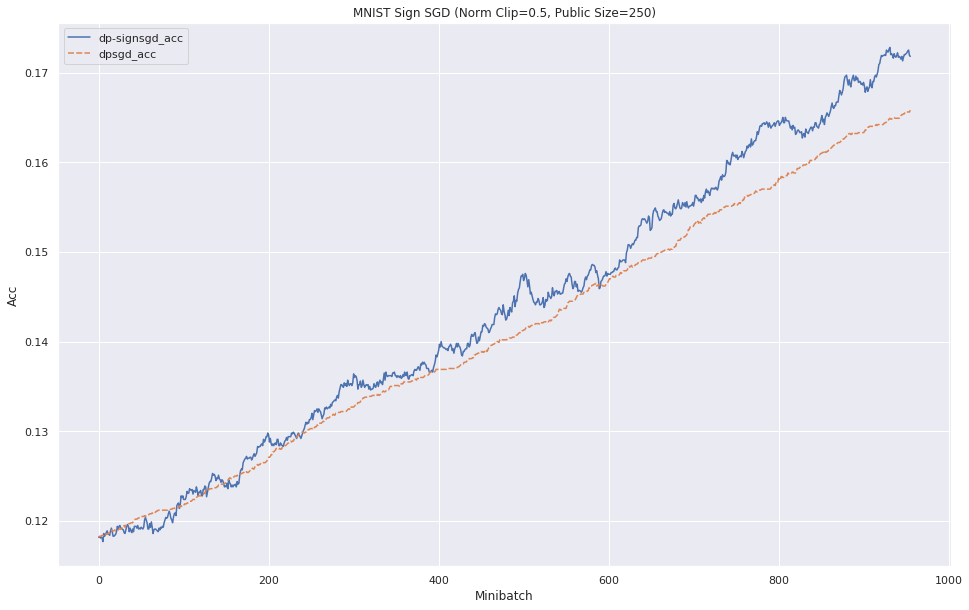

In [23]:
sns.set(rc={'figure.figsize':(16, 10)})
ax = sns.lineplot(data=metrics)
# ax.set(ylim=(0,1))
ax.set(xlabel='Minibatch', ylabel='Acc', 
       title='MNIST Sign SGD (Norm Clip={}, Public Size={})'.format(l2_norm_clip, public_data_size))
plt.savefig('mnist_abadi_signSGD_bayesian-network_dpsgd-norm{}_public{}_dp-only.png'
                    .format(l2_norm_clip, public_data_size))